In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
class CommNetLever:
    
    def __init__(self, sess, N, J, embedding_size = 128, lr = 1e-3, training_mode = 'supervised', alpha = 0.03):
        
        '''
        - N: total number of agents
        - J: number of levers (and agents randomly selected at each step)
        - embedding_size: dimension of the hidden layers 
        - lr: learning rate 
        - training_mode: 'supervised' or 'reinforce'
        - alpha: paramater used by reinforce training mode to balance reward and baseline loss
        
        '''
        
        self.N = N
        self.J = J
        self.embedding_size = embedding_size
        
        self.build_controler()
        
        self.training_mode = training_mode
        
        if training_mode == 'supervised':
            self.build_supervised()
            with tf.variable_scope('Supervised_optimizer'):
                self.train_op = tf.train.AdamOptimizer(lr).minimize(self.supervised_loss)
                
        elif training_mode == 'reinforce':
            self.alpha = 0.03
            self.build_reinforce()
            with tf.variable_scope('Reinforce_optimizer'):
                self.train_op =  tf.train.RMSPropOptimizer(lr).minimize(self.reinforce_loss)
            
        else:
            raise(ValueError("Unknown training mode: %s" % training_mode))            
        
        self.sess = sess
        self.sess.run(tf.global_variables_initializer())
        
    def encode(self, inputs):
        
        with tf.variable_scope('Encoder'):
        
            self.identity_embeddings = tf.get_variable("identity_embeddings",
                                             [self.N, self.embedding_size])
            
            self.embedded_identities = tf.nn.embedding_lookup(self.identity_embeddings, inputs)
        
            
        return tf.unstack(self.embedded_identities, axis = 1)
    
    def build_f(self, name, h, c, h0 = None):
        
        with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
            
            if h0 is not None and c is not None:
            
                b1 = tf.get_variable('b1', shape = (1, self.embedding_size))
                W1 = tf.get_variable('W1', shape = (3 * self.embedding_size,
                                                  self.embedding_size))
                
                W2 = tf.get_variable('W2', shape = (self.embedding_size,
                                                  self.embedding_size))
                
                concat = tf.concat([h, c, h0], axis = 1)
            
            elif h0 is not None and c is None: 
                b1 = tf.get_variable('b1', shape = (1, self.embedding_size))
                
                W1 = tf.get_variable('W1', shape = (2 * self.embedding_size,
                                                  self.embedding_size))
                
                W2 = tf.get_variable('W2', shape = (self.embedding_size,
                                                  self.embedding_size))
                
                concat = tf.concat([h, h0], axis = 1)
                
            elif c is not None and h0 is None:
                
                b1 = tf.get_variable('b1', shape = (1, self.embedding_size))
                
                W1 = tf.get_variable('W1', shape = (2 * self.embedding_size,
                                                  self.embedding_size))
                
                W2 = tf.get_variable('W2', shape = (self.embedding_size,
                                                  self.embedding_size))
                
                concat = tf.concat([h, c], axis = 1)
                
            else:
                
                b1 = tf.get_variable('b1', shape = (1, self.embedding_size))
                
                W1 = tf.get_variable('W1', shape = (self.embedding_size,
                                                  self.embedding_size))
                
                W2 = tf.get_variable('W2', shape = (self.embedding_size,
                                                  self.embedding_size))
                
                concat = h
                
                
            b2 = tf.get_variable('b2', shape = (1, self.embedding_size))
            
            dense1 =tf.nn.relu(tf.einsum("ij,jk->ik", concat, W1) + b1)
            dense2 = tf.nn.relu(tf.einsum("ij,jk->ik", dense1, W2) + b2)
            
            return dense2
        
    def decode(self, h):
        
        with tf.variable_scope('Decoder', reuse = tf.AUTO_REUSE):
            
            W = tf.get_variable('W', shape = (self.embedding_size,
                                                  self.J))
            
            b = tf.get_variable('b', shape = (1, self.J))
            
            policy_logit = tf.einsum("ij,jk->ik", h, W) + b
        
            return policy_logit
    
    
    def communicate(self, h_seq):
        
        # mean of hidden layers 
        return tf.add_n(h_seq) / (self.J - 1)
    
    def sample_actions(self, log_proba):
        
        action = tf.multinomial(log_proba, num_samples = 1)
        
        return action
    
        
    def build_controler(self):
        
        self.inputs = tf.placeholder(tf.int32, shape = (None, self.J))
        
        h0_seq = self.encode(self.inputs)
        c0_seq = [self.communicate([h0_seq[j] for j in range(self.J) if j != i]) for i in range(self.J)]
        
        h1_seq = [self.build_f("Comm_step_1", h0_seq[j], c0_seq[j], None) for j in range(self.J)]
        c1_seq = [self.communicate([h1_seq[j] for j in range(self.J) if j != i]) for i in range(self.J)]
        
        self.h2_seq = [self.build_f("Comm_step_2", h1_seq[j], c1_seq[j], h0_seq[j]) for j in range(self.J)]
        
        # can be used to check values of hidden states 
        self.hidden_layers = {'h0_seq': h0_seq, 'h1_seq': h1_seq, 'c1_seq':c1_seq, 'h2_seq': self.h2_seq}
        
        
        self.policy_logit_seq = [self.decode(h2) for h2 in self.h2_seq]
        self.log_proba_seq = [tf.nn.log_softmax(policy_logit, axis = 1) for policy_logit in self.policy_logit_seq]
        self.action_seq = [self.sample_actions(log_proba) for log_proba in self.log_proba_seq]
        self.one_hot_action_seq = [tf.one_hot(action, depth = self.J) for action in self.action_seq]
        
        
        
    def build_supervised(self):
        
        assert self.training_mode == 'supervised', 'Wrong training mode'
        
        self.targets = tf.placeholder(tf.int32, shape = (None, self.J))
        unstacked_targets = tf.unstack(self.targets, axis = 1)
        
        supervised_loss_seq = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=unstacked_targets[j],
                                                                                   logits=self.policy_logit_seq[j])
                                    for j in range(self.J)]
        
        self.supervised_loss = tf.reduce_mean(supervised_loss_seq)
        
        
    def supervised_train(self, X, y, val_X, val_y, env, batch_size = 32, epochs = 1):
    
            
        assert self.training_mode == 'supervised', 'Wrong training mode'
        
        n = X.shape[0]
        
        val_n = val_X.shape[0]
        
        data_inds = np.array(range(n))
        for ep in range(1, epochs + 1):
            # shuffle data for each epoch
            np.random.shuffle(data_inds)
            
            supervised_loss_sum = 0
            reward_sum = 0
            for i in tqdm_notebook(range(0, n, batch_size), "Epoch: %d" % ep):
                
                # select batch data
                inds_batch = data_inds[i:i+batch_size]
                X_batch = X[inds_batch]
                y_batch = y[inds_batch]
                
                # train on batch
                _, supervised_loss, one_hot_action_seq = sess.run([self.train_op, self.supervised_loss, self.one_hot_action_seq], feed_dict={self.inputs: X_batch, self.targets: y_batch})
               
                # keep track of the loss and reward
                supervised_loss_sum += supervised_loss * batch_size
                reward_sum += env.get_reward(one_hot_action_seq)
            
            print("loss = %f" % (supervised_loss_sum / n))
            print("reward = %f" % (reward_sum / n))
            print()
            
            # eval loss and reward on validation set
            val_supervised_loss, val_one_hot_action_seq = sess.run([self.supervised_loss, self.one_hot_action_seq], feed_dict={self.inputs: val_X, self.targets: val_y})
            print('val loss = %f' % (val_supervised_loss))
            print('val reward = %f' % (env.get_reward(val_one_hot_action_seq) / val_n))
            
    def build_baseline(self, h):
        
        '''state specific baseline for reinforce training mode is given by a simple FC layer
        connected to the last hidden layer of the controler
        '''
        
        assert self.training_mode == 'reinforce', 'Wrong training mode'
        
        with tf.variable_scope('Baseline', reuse = tf.AUTO_REUSE):
            
            W = tf.get_variable('W', shape = (self.embedding_size,
                                                  1))
            
            b = tf.get_variable('b', shape = (1,))
            
            
            baseline = tf.einsum("ij,jk->ik", h, W) + b
            
            return baseline
            

    def build_reinforce(self):
        
        assert self.training_mode == 'reinforce', 'Wrong training mode'
        
        # only used for scattering 
        self.indices = tf.placeholder(tf.int32, shape = (None, 2))
        self.shape = tf.placeholder(tf.int32, shape =(2,))
        
        # baseline tensors
        self.baselines = tf.concat([self.build_baseline(h2) for h2 in self.h2_seq], axis = 1)
        self.scattered_baselines = tf.scatter_nd(self.indices, tf.reshape(self.baselines, [-1]), shape = self.shape)
                    
        # reward values
        self.repeated_reward_values = tf.placeholder(tf.float32, shape = (None,))
        self.scattered_reward_values = tf.scatter_nd(self.indices, self.repeated_reward_values, shape = self.shape)
        self.scattered_reward_values_cumsum = tf.cumsum(self.scattered_reward_values, axis = 0, reverse = True)
        
        # baseline values
        self.baseline_values =  tf.placeholder(tf.float32, shape = (None, self.J))
        self.scattered_baseline_values = tf.scatter_nd(self.indices, tf.reshape(self.baseline_values, [-1]), shape = self.shape)
        
        # actions that have been taken
        self.action_taken = tf.placeholder(tf.int32, shape = (None, self.J))
        unstacked_action_taken = tf.unstack(self.action_taken, axis = 1)
        
        # neg log proba of taken actions
        self.neg_log_p = tf.transpose(tf.concat([[tf.nn.sparse_softmax_cross_entropy_with_logits(labels=unstacked_action_taken[j],
                                                    logits=self.policy_logit_seq[j])] for j in range(self.J)], axis = 0))
        self.scattered_neg_log_p = tf.scatter_nd(self.indices, tf.reshape(self.neg_log_p, [-1]), shape = self.shape)
        
        #surrogate loss (- dtheta)
        self.reinforce_loss = tf.reduce_sum(tf.multiply(self.scattered_neg_log_p, self.scattered_reward_values_cumsum - self.scattered_baseline_values))
        self.reinforce_loss += self.alpha * tf.reduce_sum(tf.square(self.scattered_reward_values_cumsum - self.scattered_baselines))
        self.reinforce_loss /= self.J
        
        
    def take_action(self, state):
        
        assert self.training_mode == 'reinforce', 'Wrong training mode'
        
        action_seq, baselines= self.sess.run([self.action_seq, self.baselines], {self.inputs: [state]})
        
        return [a[0,0] for a in action_seq], baselines
    
    def reinforce_train(self, env, n_episodes, T):
        
        assert self.training_mode == 'reinforce', 'Wrong training mode'
        
        history = {'reward' : [],  'loss': []}    
        
        for _ in tqdm_notebook(range(n_episodes), "REINFORCE"):
            
            
            state_seq, action_seq, reward_seq, baseline_seq = policy_rollout(T, env, self)
            episode_len = reward_seq.shape[0]
            
            history['reward'].append(np.mean(reward_seq))
            
            repeated_t = np.repeat(np.arange(episode_len), self.J)
            
            indices = np.vstack([repeated_t, state_seq.ravel()]) .T
                
            feed_dict = {}
            feed_dict[self.inputs] = state_seq
            feed_dict[self.indices] = indices
            feed_dict[self.shape] = [episode_len, self.N]
            feed_dict[self.repeated_reward_values] = np.repeat(reward_seq, self.J)
            feed_dict[self.baseline_values] = baseline_seq
            feed_dict[self.action_taken] = action_seq
            
            _, loss = self.sess.run([self.train_op, self.reinforce_loss], feed_dict = feed_dict)
            
            history['loss'].append(loss)
            
            
        return history
            
            
            
            
            
            
            
        

In [3]:
class LeverEnv:
    
    def __init__(self, N, J):
        
        self.J = J
        self.N = N
        
    def reset(self):
        
        state = np.random.choice(self.N, size = self.J, replace = False)
        
        terminal_state = False
        
        return state, terminal_state
    
    def get_reward(self, one_hot_action_seq):        
        
        reward = np.sum(np.sum(one_hot_action_seq, axis = 0) > 0) /self.J
        
        return reward
        
    def step(self, state, action):
        
        next_state = np.random.choice(self.N, size = self.J, replace = False)
        
        one_hot_action_seq = np.zeros((self.J, self.J))
        one_hot_action_seq[range(self.J), action] = 1
        reward = self.get_reward(one_hot_action_seq)
        
        terminal_state = False
        
        return next_state, reward, terminal_state
        

In [4]:

def generate_data(n, N, J):
    
    '''
    Generates data for supervised learning
    
    '''
    
    X = np.empty((n, J), dtype = int)
    y= np.empty((n,J), dtype = int)
    
    for i in range(n):
        
        X[i] = np.random.choice(N, size = J, replace = False)
        sorted_args = np.argsort(X[i])
        y[i] = np.argsort(sorted_args)
        
    return X, y

In [5]:
def policy_rollout(T, env, agent):
    
    '''
    Simulate one episode of length T at most
    '''
    
    state_seq = []
    action_seq = []
    reward_seq = []
    baseline_seq = []
    
    
    state, terminal_state = env.reset()
    
    t = 0
    
    while not terminal_state and t < T:
        t +=1
        
        state_seq.append(state)
        action, baseline = agent.take_action(state)
        
        state, reward, terminal_state = env.step(state, action)
        
        
        action_seq.append(action)
        reward_seq.append(reward)
        baseline_seq.append(baseline)
        
    return np.array(state_seq), np.array(action_seq), np.array(reward_seq), np.squeeze(np.array(baseline_seq))

# Supervised learning

In [6]:
N = 500
J = 5

In [7]:
batch_size = 64
n = batch_size * 10
X, y = generate_data(n, N, J)
val_X, val_y = generate_data(500, N, J)

In [8]:
tf.reset_default_graph()
with tf.Session() as sess:
    commNet = CommNetLever(sess, N, J, lr = 1e-3, embedding_size= 128, training_mode = 'supervised')
    env = LeverEnv(N, J)
    commNet.supervised_train(X, y, val_X, val_y, env, batch_size = batch_size, epochs = 1)

HBox(children=(IntProgress(value=0, description='Epoch: 1', max=10, style=ProgressStyle(description_width='initial')), HTML(value='')))


loss = 1.663017
reward = 0.647812

val loss = 1.608635
val reward = 0.665200


# REINFORCE

In [9]:
tf.reset_default_graph()
with tf.Session() as sess:
    commNet = CommNetLever(sess, N, J, lr = 1e-3, embedding_size= 128, training_mode = 'reinforce')
    env = LeverEnv(N, J)
    
    history = commNet.reinforce_train(env, n_episodes = 10, T =64)

HBox(children=(IntProgress(value=0, description='REINFORCE', max=10, style=ProgressStyle(description_width='initial')), HTML(value='')))

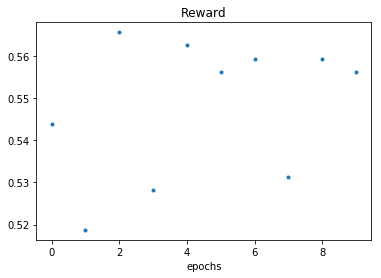

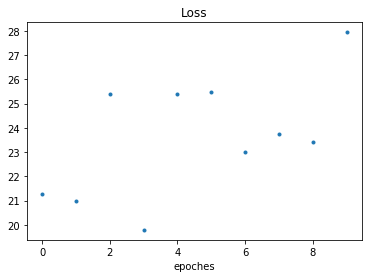

In [10]:
plt.title('Reward')
plt.plot(history['reward'], '.')
plt.xlabel('epochs')
plt.show()
plt.title('Loss')
plt.plot(history['loss'], '.')
plt.xlabel('epoches')
plt.show()